In [11]:
import glob
from pathlib import Path
import os, sys
import copy
from time import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec

import pandas as pd
from PIL import Image

import qgm
from qgm import image, parameter, filter, data, fitting, function
from qgm.image import pixel_shift
from qgm import search_atoms
from qgm.deconvolution import deconvolution

from qgm import evaluation
plt.style.use("default")

from scipy import optimize
import scipy.optimize

In [12]:
date = '20211208'
dataNo = 2
scanNo = 2

In [13]:
path = os.getcwd()  +r'/'+ date
path_img = path + r"/data" + str('%03d' % dataNo) + r"/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')
fit_data = pd.read_csv('SF_MI_center_width.csv')

In [14]:
param_name = 'A0157: OL (H1): AM for physics 2'
scan_param =3.4/4*np.exp((scan_data[param_name]-5.03)/0.646)
unique_param = scan_param.unique()
total_count = scan_data["Total count1 @ ROI1 (arb. u.)"]
cx_list = fit_data["Center X (px)"]
cy_list = fit_data["Center Y (px)"]
sigx_list = fit_data["Sigma X (px)"]
sigy_list = fit_data["Sigma Y (px)"]

## Sample image

In [15]:
seq_no = 10

In [16]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print("No Data")

img1 = image.image(trans_files[seq_no])
img1.generate_bg_image(path_img +r'/seq00000_flat001.tiff', True)

cmap = image.generate_cmap(['#330000', 'r', 'w'])
iter_deconv = 10

In [94]:
(x0_px, y0_px) = (cx_list[seq_no],
                  cy_list[seq_no]) # px
(x0_um, y0_um) = (x0_px*0.18782061063985978, y0_px*0.18782061063985978) # um

system_info = {'Magnification': 85.18766894374285,
               'Cloud center (px)': (x0_px, y0_px),
               'Cloud center (um)': (x0_um, y0_um),
              }

img1.system.set_info(**system_info)
img1.system.recalc_effective_pixel_size()

lattice1_info = {'Constant (px)': 3.770261,
                 'Constant (um)': 3.770261 * 0.18782061063985978,
                 'Angle (degree)': 19.849774260122633,
                 'Angle (radian)': 19.849774260122633 * np.pi / 180,
                }
lattice2_info = {'Constant (px)': 3.792326,
                 'Constant (um)': 3.792326 * 0.18782061063985978,
                 'Angle (degree)': 79.63134796355473,
                 'Angle (radian)': 79.63134796355473 * np.pi / 180,
                }
img1.system.lattice['Lattice 1'].set_info(**lattice1_info)
img1.system.lattice['Lattice 2'].set_info(**lattice2_info)

psf_info = {'Model':'psf',
            'Effective NA': 0.592501443972206,
            'Offset count': 0,
            'Peak count': 2500,
           }
img1.system.psf.set_info(**psf_info)
img1.system.psf.recalc_resolution()

xymesh = img1.generate_xymesh()

Magnification
Cloud center (px)
Cloud center (um)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Model
Effective NA
Offset count
Peak count


In [18]:
img1_lowpass = copy.deepcopy(img1)
img1_lowpass.image, img_fft, (fx, fy), (FX, FY) = filter.lowpass(img1_lowpass, factor=1)

In [19]:
_ = search_atoms.search_atoms(img1, filter_factor=0.2)
_ = search_atoms.search_atoms(img1_lowpass, filter_factor=0.2)

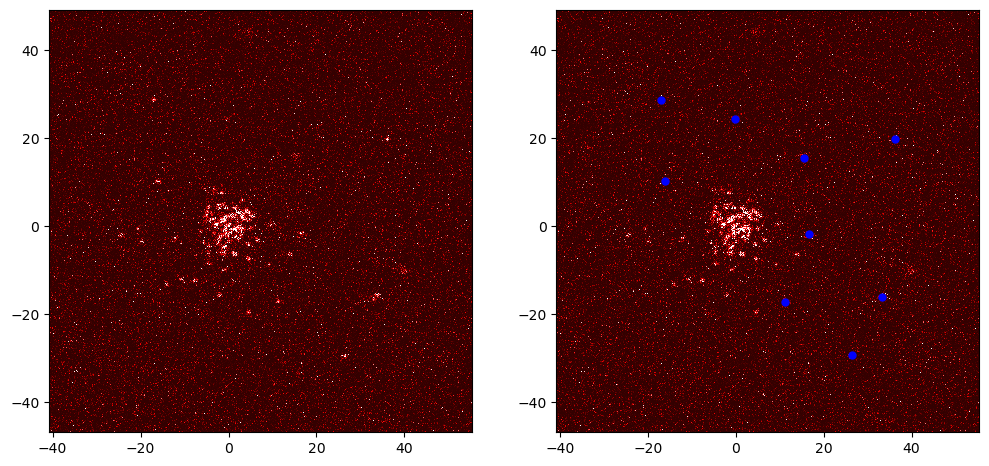

In [20]:
fig = plt.figure(figsize=(12,8), dpi=100)

plt.subplot(1, 2, 1)
plt.pcolormesh(img1.xymesh[0], img1.xymesh[1], img1.image, cmap=cmap, vmin=0, vmax=1200)
# plt.plot(img1.system.lattice['Origins']['X Center (um)'], img1.system.lattice['Origins']['Y Center (um)'], '.', alpha=0.5)
plt.gca().set_aspect('equal')

plt.subplot(1, 2, 2)
plt.pcolormesh(img1.xymesh[0], img1.xymesh[1], img1.image, cmap=cmap, vmin=0, vmax=1200)
plt.plot(img1.system.lattice['Origins']['X Center (um)'], img1.system.lattice['Origins']['Y Center (um)'], '.', markersize=10, alpha=1,c ="blue")
plt.gca().set_aspect('equal')

In [21]:
(x0_sub, x1_sub, y0_sub, y1_sub) = np.array(0.5*0.18782061063985978)*(-sigx_list[seq_no], sigx_list[seq_no], -sigy_list[seq_no], sigy_list[seq_no])
# (x0_sub, x1_sub, y0_sub, y1_sub) = (-5, 5, -5, 5)

In [22]:
img1.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])
img1_lowpass.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])
xymesh_ROI = img1.xymesh_ROI

In [23]:
(xs1, ys1) = img1.generate_lattice_sites(Nsite=201, rxlim=15, rylim=15, unit='um', limits='square')
(xs1_lowpass, ys1_lowpass) = img1_lowpass.generate_lattice_sites(Nsite=201, rxlim=15, rylim=15, unit='um', limits='square')

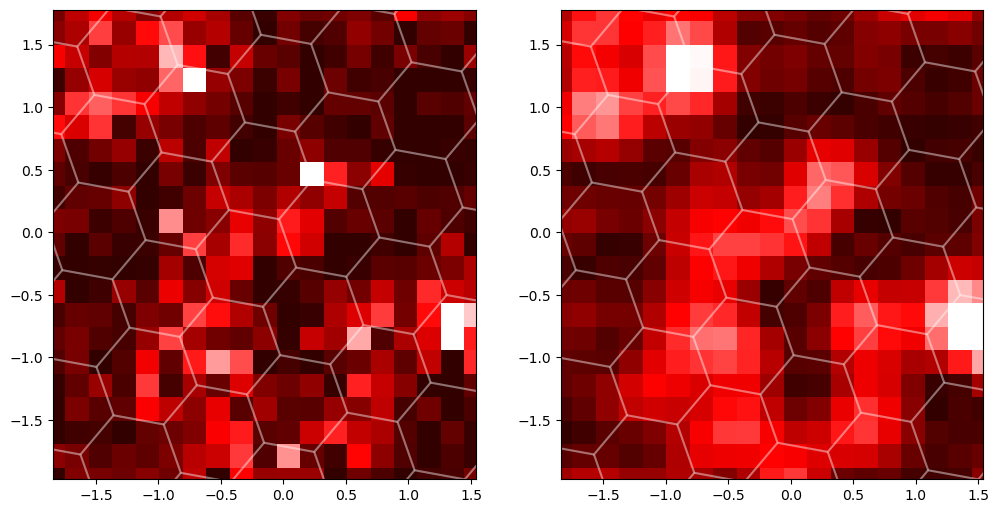

In [24]:
sep_lattice1 = img1.generate_lattice_separation(alpha=0.25, dx=-0.3, dy=-0.21)
sep_lattice1_lowpass = img1_lowpass.generate_lattice_separation(alpha=0.25, dx=-0.25, dy=-0.21)

plt.figure(figsize=(12, 8), dpi=100)

for n, (img, sep_lattice) in enumerate(zip([img1, img1_lowpass], [sep_lattice1, sep_lattice1_lowpass])):
    g = plt.subplot(1, 2, n+1)
    plt.pcolormesh(img.xymesh_ROI[0], img.xymesh_ROI[1], img.image_ROI, cmap=cmap, vmin=0, vmax=np.max(img.image_ROI)*0.8)
#     plt.plot(img.system.lattice['Lattice sites']['X Center'], img1.system.lattice['Lattice sites']['Y Center'], '.', alpha=0.5)
    g.add_collection(sep_lattice)
    plt.xlim([np.min(img.xymesh_ROI[0]), np.max(img.xymesh_ROI[0])])
    plt.ylim([np.min(img.xymesh_ROI[1]), np.max(img.xymesh_ROI[1])])
    plt.gca().set_aspect('equal')

plt.show()

In [25]:
if False:
    img1_test = copy.deepcopy(img1)
else:
    img1_test = copy.deepcopy(img1_lowpass)

In [26]:
img1_test.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])
xymesh_ROI = img1_test.xymesh_ROI
(xs1_test, ys1_test) = img1_test.generate_lattice_sites(Nsite=401, rxlim=16, rylim=16, unit='um', limits='square')

In [27]:
img1_test.system.lattice['Lattice sites']['X Center'] += 0
img1_test.system.lattice['Lattice sites']['Y Center'] += 0

xs1_test = img1_test.system.lattice['Lattice sites']['X Center']
ys1_test = img1_test.system.lattice['Lattice sites']['Y Center']

In [28]:
t1 = time()

if True:
    img1_test.generate_psfm(psf_model='gaussian')    
else:
    img1_test.generate_psfm()    
t2 = time()

print('Elapsed time: %f s' % (t2 -t1))

Elapsed time: 0.029888 s


In [29]:
img1_test_dec, factor_evol1 = deconvolution(img1_test, Niter=iter_deconv)


In [30]:
threshold = 5000.0

img1_test_eval = evaluation.site_occupation_evaluation(img1_test, threshold=threshold)

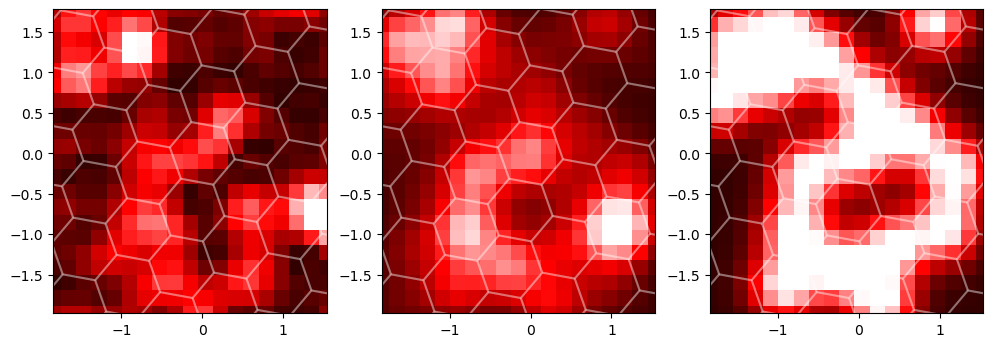

In [31]:
plt.figure(figsize=(12, 8), dpi=100)

imgs = [img1_test.image_ROI, img1_test_dec, img1_test_eval]

for n, img in enumerate(imgs):
    sep_lattice = img1_test.generate_lattice_separation(alpha=0.25)
    
    g = plt.subplot(1, 3, n+1)
    plt.pcolormesh(xymesh_ROI[0], xymesh_ROI[1], img, cmap=cmap, vmin=0, vmax=np.max(img)*8/10)
#     plt.plot(xs1_test, ys1_test, '.', alpha=0.5)
    g.add_collection(sep_lattice)
    plt.xlim([np.min(xymesh_ROI[0]), np.max(xymesh_ROI[0])])
    plt.ylim([np.min(xymesh_ROI[1]), np.max(xymesh_ROI[1])])
    plt.gca().set_aspect('equal')

plt.show()

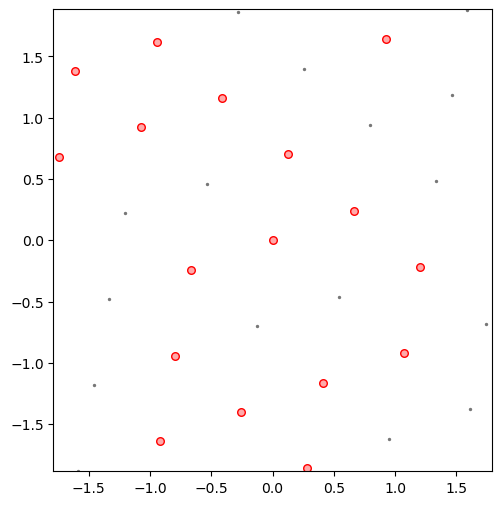

In [32]:
x0_um = img1_test.system.lattice['Lattice sites']['X Center']
y0_um = img1_test.system.lattice['Lattice sites']['Y Center']

flag1 = img1_test.system.lattice['Lattice sites']['Amplitude'] > threshold

x0_img1 = img1_test.system.lattice['Lattice sites']['X Center'][flag1]
y0_img1 = img1_test.system.lattice['Lattice sites']['Y Center'][flag1]

plt.figure(figsize=(6, 6), dpi=100)
plt.scatter(x0_um, y0_um, marker='.', s=8, fc='#777777', zorder=0)
plt.scatter(x0_img1, y0_img1, s=30, marker='o', fc='#ffaaaa', ec='r')
plt.xlim([x0_sub, x1_sub])
plt.ylim([y0_sub, y1_sub])
plt.gca().set_aspect(1)

plt.show()

In [33]:
total_size = (np.max(img1_test.system.lattice['Lattice sites']['X Center'])-np.min(img1_test.system.lattice['Lattice sites']['X Center']))*(np.max(img1_test.system.lattice['Lattice sites']['Y Center'])-np.min(img1_test.system.lattice['Lattice sites']['Y Center']))
roi_size = (x1_sub - x0_sub)*(y1_sub - y0_sub)
site_num = np.round(np.shape(img1_test.system.lattice['Lattice sites']['X Center'])[0]*roi_size/total_size)

atom_num = np.array(0)
for i in range(len(flag1)):
    if flag1[i] == True:
        atom_num += np.array(1)

print("Filling = " + str(atom_num/site_num))

Filling = 0.5483870967741935


## Calculate filling for each image

In [107]:
filling_list = []
prop_to_sigma = 0.3

for i in range(len(trans_files)):
    if i == 407 or i == 460 :
        filling_list.append('')
    else:
        #load image
        seq_no = i
        img1 = image.image(trans_files[seq_no])
        img1.generate_bg_image(path_img +r'/seq00000_flat001.tiff', True)
        
        #set parameters
        (x0_px, y0_px) = (cx_list[seq_no],cy_list[seq_no]) # px
        (x0_um, y0_um) = (x0_px*0.18782061063985978, y0_px*0.18782061063985978) # um
        system_info = {'Magnification': 85.18766894374285,'Cloud center (px)': (x0_px, y0_px),'Cloud center (um)': (x0_um, y0_um),}
        img1.system.set_info(**system_info)
        img1.system.recalc_effective_pixel_size()
        img1.system.lattice['Lattice 1'].set_info(**lattice1_info)
        img1.system.lattice['Lattice 2'].set_info(**lattice2_info)
        img1.system.psf.set_info(**psf_info)
        img1.system.psf.recalc_resolution()
        xymesh = img1.generate_xymesh()
        
        #Apply lowpass filter
        img1_lowpass = copy.deepcopy(img1)
        img1_lowpass.image, img_fft, (fx, fy), (FX, FY) = filter.lowpass(img1_lowpass, factor=1)

        #Search for isolated atoms
        _ = search_atoms.search_atoms(img1, filter_factor=0.02)
        _ = search_atoms.search_atoms(img1_lowpass, filter_factor=0.02)

        #Set ROI
        (x0_sub, x1_sub, y0_sub, y1_sub) = np.array(prop_to_sigma*0.18782061063985978)*(-sigx_list[seq_no], sigx_list[seq_no], -sigy_list[seq_no], sigy_list[seq_no])
        img1.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])
        img1_lowpass.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])
        xymesh_ROI = img1.xymesh_ROI
        (xs1, ys1) = img1.generate_lattice_sites(Nsite=201, rxlim=15, rylim=15, unit='um', limits='square')
        (xs1_lowpass, ys1_lowpass) = img1_lowpass.generate_lattice_sites(Nsite=201, rxlim=15, rylim=15, unit='um', limits='square')
        sep_lattice1 = img1.generate_lattice_separation(alpha=0.25, dx=-0.3, dy=-0.21)
        sep_lattice1_lowpass = img1_lowpass.generate_lattice_separation(alpha=0.25, dx=-0.25, dy=-0.21)
        if False:
            img1_test = copy.deepcopy(img1)
        else:
            img1_test = copy.deepcopy(img1_lowpass)
        
        img1_test.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])
        xymesh_ROI = img1_test.xymesh_ROI
        (xs1_test, ys1_test) = img1_test.generate_lattice_sites(Nsite=401, rxlim=16, rylim=16, unit='um', limits='square')
        img1_test.system.lattice['Lattice sites']['X Center'] += 0
        img1_test.system.lattice['Lattice sites']['Y Center'] += 0
        xs1_test = img1_test.system.lattice['Lattice sites']['X Center']
        ys1_test = img1_test.system.lattice['Lattice sites']['Y Center']
        if True:
            img1_test.generate_psfm(psf_model='gaussian')    
        else:
            img1_test.generate_psfm()    
        
        #Deconvolution
        img1_test_dec, factor_evol1 = deconvolution(img1_test, Niter=iter_deconv)

        #Evaluation
        threshold = 5000.0
        img1_test_eval = evaluation.site_occupation_evaluation(img1_test, threshold=threshold)
        
        #Calculate filling
        x0_um = img1_test.system.lattice['Lattice sites']['X Center']
        y0_um = img1_test.system.lattice['Lattice sites']['Y Center']
        flag1 = img1_test.system.lattice['Lattice sites']['Amplitude'] > threshold

        total_size = (np.max(img1_test.system.lattice['Lattice sites']['X Center'])-np.min(img1_test.system.lattice['Lattice sites']['X Center']))*(np.max(img1_test.system.lattice['Lattice sites']['Y Center'])-np.min(img1_test.system.lattice['Lattice sites']['Y Center']))
        roi_size = (x1_sub - x0_sub)*(y1_sub - y0_sub)
        site_num = np.round(np.shape(img1_test.system.lattice['Lattice sites']['X Center'])[0]*roi_size/total_size)
        atom_num = np.array(0)
        for i in range(len(flag1)):
            if flag1[i] == True:
                atom_num += np.array(1)
        filling_list.append(atom_num/site_num)

Magnification
Cloud center (px)
Cloud center (um)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Model
Effective NA
Offset count
Peak count
Magnification
Cloud center (px)
Cloud center (um)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Model
Effective NA
Offset count
Peak count
Magnification
Cloud center (px)
Cloud center (um)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Model
Effective NA
Offset count
Peak count
Magnification
Cloud center (px)
Cloud center (um)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Model
Effective NA
Offset count
Peak count
Magnification
Cloud center (px)
Cloud center (um)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian

In [108]:
filling_2_list = []
filling_2_err_list = []

for i in range(len(unique_param)):
    filling_temp = []
    for j in range(len(filling_list)):
        if scan_param[j] == unique_param[i]:
            if filling_list[j] == '':
                continue
            else:
                filling_temp.append(filling_list[j])
    filling_2_list.append(np.mean(filling_temp))
    filling_2_err_list.append(np.std(filling_temp))

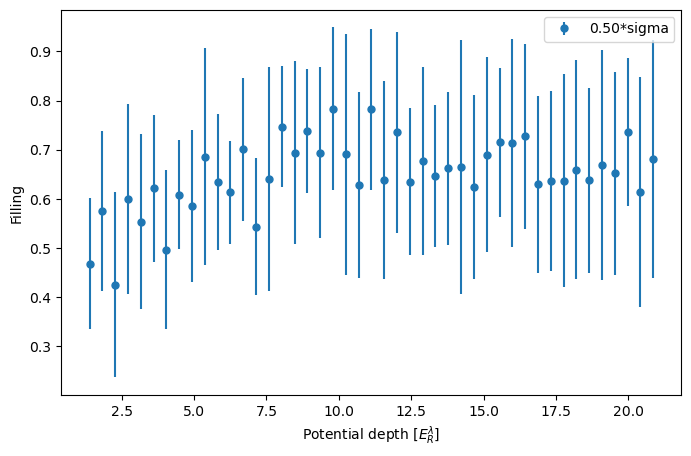

In [109]:
prop_to_sigma = 0.5

fig = plt.figure(figsize=[8,5])
ax1 = fig.add_subplot(1,1,1)
ax1.errorbar(unique_param,filling_2_list,filling_2_err_list,fmt='o',markersize=5,label="{:.2f}*sigma".format(prop_to_sigma))
ax1.set_ylabel("Filling")
ax1.set_xlabel(r"Potential depth [$E_R^{\lambda}$]")
ax1.legend()

Text(0, 0.5, '$log_{10}[U/(6J)]$')

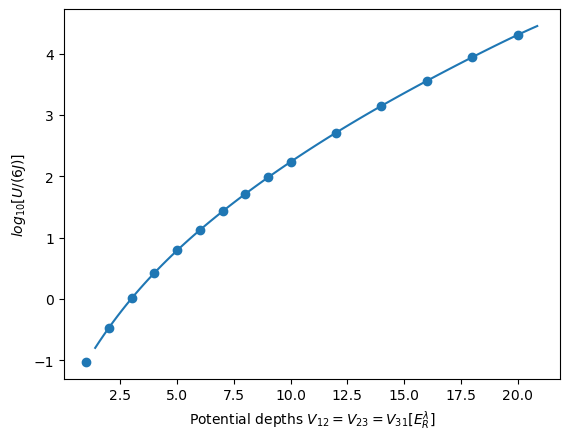

In [110]:
## Hubbard parameters for each potential depth
depth = np.array([1,2,3,4,5,6,7,8,9,10,12,14,16,18,20])
u_ov_6t = np.array([0.09423759108,0.3405272348,1.039420807,2.675594004,6.195279846,13.2800499,26.83593553,51.74380519,96.0052570,172.4697909,514.2282016,1408.480766,3606.249368,8736.47373,20204.02751])
z = np.polyfit(depth, np.log10(u_ov_6t), 7)
p = np.poly1d(z)
x_list = np.linspace(np.min(unique_param),np.max(unique_param),100)

plt.scatter(depth, np.log10(u_ov_6t))
plt.plot(x_list,p(x_list))
plt.xlabel(r'Potential depths $V_{12}=V_{23}=V_{31}[E_R^{\lambda}]$')
plt.ylabel(r'$log_{10}[U/(6J)]$')

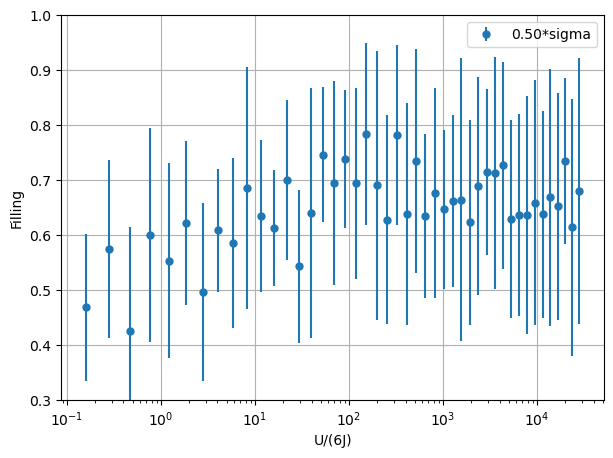

In [111]:
fig = plt.figure(figsize=[7,5])
ax1 = fig.add_subplot(1,1,1)
ax1.errorbar(10**p(unique_param),filling_2_list,filling_2_err_list,fmt='o',markersize=5,label="{:.2f}*sigma".format(prop_to_sigma))
ax1.set_xscale("log")
ax1.set_ylabel("Filling")
ax1.set_xlabel(r"U/(6J)")
ax1.set_ylim(0.3,1)
ax1.grid()
ax1.legend()

In [112]:
width_list = [1,0.8,0.6,0.4,0.2]
filling_3_list = []
for i in range(len(width_list)):
    filling_curr_row = []
    for j in range(len(filling_2_list)):
        filling_curr_row.append(filling_2_list[j])
    filling_3_list.append(filling_curr_row)

In [136]:
filling_list = []
# width_list = np.arange(0.2,1.1,0.1)
width_list = np.arange(0.2,1.0,0.1)


for k in range(len(width_list)):
    prop_to_sigma = width_list[k]
    filling_curr_row = []
    for i in range(len(trans_files)):
        if i == 407 or i == 460 :
            filling_curr_row.append('')
        else:
            #load image
            seq_no = i
            img1 = image.image(trans_files[seq_no])
            img1.generate_bg_image(path_img +r'/seq00000_flat001.tiff', True)
            
            #set parameters
            (x0_px, y0_px) = (cx_list[seq_no],cy_list[seq_no]) # px
            (x0_um, y0_um) = (x0_px*0.18782061063985978, y0_px*0.18782061063985978) # um
            system_info = {'Magnification': 85.18766894374285,'Cloud center (px)': (x0_px, y0_px),'Cloud center (um)': (x0_um, y0_um),}
            img1.system.set_info(**system_info)
            img1.system.recalc_effective_pixel_size()
            img1.system.lattice['Lattice 1'].set_info(**lattice1_info)
            img1.system.lattice['Lattice 2'].set_info(**lattice2_info)
            img1.system.psf.set_info(**psf_info)
            img1.system.psf.recalc_resolution()
            xymesh = img1.generate_xymesh()
            
            #Apply lowpass filter
            img1_lowpass = copy.deepcopy(img1)
            img1_lowpass.image, img_fft, (fx, fy), (FX, FY) = filter.lowpass(img1_lowpass, factor=1)

            #Search for isolated atoms
            _ = search_atoms.search_atoms(img1, filter_factor=0.02)
            _ = search_atoms.search_atoms(img1_lowpass, filter_factor=0.02)

            #Set ROI
            (x0_sub, x1_sub, y0_sub, y1_sub) = np.array(prop_to_sigma*0.18782061063985978)*(-sigx_list[seq_no], sigx_list[seq_no], -sigy_list[seq_no], sigy_list[seq_no])
            img1.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])
            img1_lowpass.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])
            xymesh_ROI = img1.xymesh_ROI
            (xs1, ys1) = img1.generate_lattice_sites(Nsite=201, rxlim=15, rylim=15, unit='um', limits='square')
            (xs1_lowpass, ys1_lowpass) = img1_lowpass.generate_lattice_sites(Nsite=201, rxlim=15, rylim=15, unit='um', limits='square')
            sep_lattice1 = img1.generate_lattice_separation(alpha=0.25, dx=-0.3, dy=-0.21)
            sep_lattice1_lowpass = img1_lowpass.generate_lattice_separation(alpha=0.25, dx=-0.25, dy=-0.21)
            if False:
                img1_test = copy.deepcopy(img1)
            else:
                img1_test = copy.deepcopy(img1_lowpass)
            
            img1_test.set_ROI(ROI=[x0_sub, x1_sub, y0_sub, y1_sub])
            xymesh_ROI = img1_test.xymesh_ROI
            (xs1_test, ys1_test) = img1_test.generate_lattice_sites(Nsite=401, rxlim=16, rylim=16, unit='um', limits='square')
            img1_test.system.lattice['Lattice sites']['X Center'] += 0
            img1_test.system.lattice['Lattice sites']['Y Center'] += 0
            xs1_test = img1_test.system.lattice['Lattice sites']['X Center']
            ys1_test = img1_test.system.lattice['Lattice sites']['Y Center']
            if True:
                img1_test.generate_psfm(psf_model='gaussian')    
            else:
                img1_test.generate_psfm()    
            
            #Deconvolution
            img1_test_dec, factor_evol1 = deconvolution(img1_test, Niter=iter_deconv)

            #Evaluation
            threshold = 5000.0
            img1_test_eval = evaluation.site_occupation_evaluation(img1_test, threshold=threshold)
            
            #Calculate filling
            x0_um = img1_test.system.lattice['Lattice sites']['X Center']
            y0_um = img1_test.system.lattice['Lattice sites']['Y Center']
            flag1 = img1_test.system.lattice['Lattice sites']['Amplitude'] > threshold

            total_size = (np.max(img1_test.system.lattice['Lattice sites']['X Center'])-np.min(img1_test.system.lattice['Lattice sites']['X Center']))*(np.max(img1_test.system.lattice['Lattice sites']['Y Center'])-np.min(img1_test.system.lattice['Lattice sites']['Y Center']))
            roi_size = (x1_sub - x0_sub)*(y1_sub - y0_sub)
            site_num = np.round(np.shape(img1_test.system.lattice['Lattice sites']['X Center'])[0]*roi_size/total_size)
            atom_num = np.array(0)
            for i in range(len(flag1)):
                if flag1[i] == True:
                    atom_num += np.array(1)
            # filling_list.append(atom_num/site_num)
            filling_curr_row.append(atom_num/site_num)
    filling_list.append(filling_curr_row)

Magnification
Cloud center (px)
Cloud center (um)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Model
Effective NA
Offset count
Peak count
Magnification
Cloud center (px)
Cloud center (um)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Model
Effective NA
Offset count
Peak count
Magnification
Cloud center (px)
Cloud center (um)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Model
Effective NA
Offset count
Peak count
Magnification
Cloud center (px)
Cloud center (um)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Model
Effective NA
Offset count
Peak count
Magnification
Cloud center (px)
Cloud center (um)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian)
Constant (px)
Constant (um)
Angle (degree)
Angle (radian

In [137]:
filling_2_list = []
filling_2_err_list = []

for k in range(len(width_list)):
    filling_2_curr_row = []
    filling_2_err_curr_row = []
    for i in range(len(unique_param)):
        filling_temp = []
        for j in range(len(filling_list[k])):
            if scan_param[j] == unique_param[i]:
                if filling_list[k][j] == '':
                    continue
                else:
                    filling_temp.append(filling_list[k][j])
        filling_2_curr_row.append(np.mean(filling_temp))
        filling_2_err_curr_row.append(np.std(filling_temp))
    filling_2_list.append(filling_2_curr_row)
    filling_2_err_list.append(filling_2_err_curr_row)

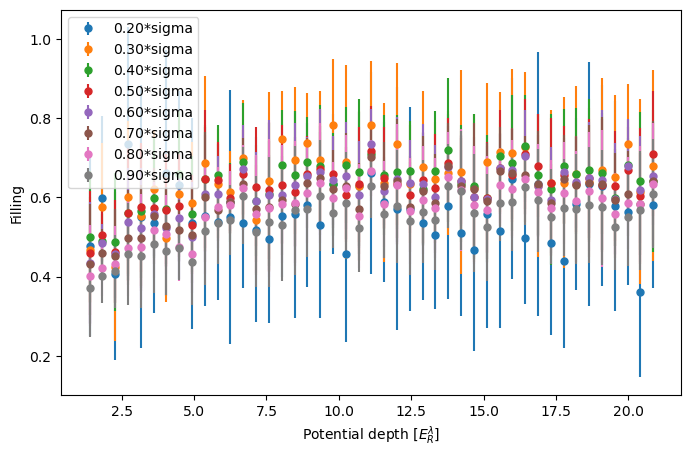

In [146]:
fig = plt.figure(figsize=[8,5])
ax1 = fig.add_subplot(1,1,1)
for i in range(len(width_list)):
    ax1.errorbar(unique_param,filling_2_list[i],filling_2_err_list[i],fmt='o',markersize=5,label="{:.2f}*sigma".format(width_list[i]))
ax1.set_ylabel("Filling")
ax1.set_xlabel(r"Potential depth [$E_R^{\lambda}$]")
ax1.legend()

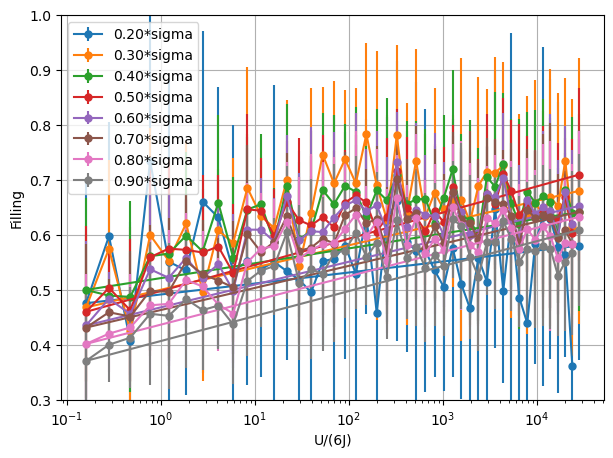

In [271]:
fig = plt.figure(figsize=[7,5])
ax1 = fig.add_subplot(1,1,1)
for i in range(len(width_list)):
    ax1.errorbar(10**p(unique_param),filling_2_list[i],filling_2_err_list[i],fmt='-o',markersize=5,label="{:.2f}*sigma".format(width_list[i]))
ax1.set_xscale("log")
ax1.set_ylabel("Filling")
ax1.set_xlabel(r"U/(6J)")
ax1.set_ylim(0.3,1)
ax1.grid()
ax1.legend()

In [287]:
names = ["Unique param"]
for i in range(len(width_list)):
    name_temp = "filling within {:.02f} sigma".format(width_list[i])
    names.append(name_temp)
for i in range(len(width_list)):
    name_temp = "filling err within {:.02f} sigma".format(width_list[i])
    names.append(name_temp)

data_for_sort = pd.DataFrame(index = range(len(unique_param)),columns = names)
data_for_sort["Unique param"] = unique_param
for i in range(len(width_list)):
    name_temp = "filling within {:.02f} sigma".format(width_list[i])
    data_for_sort[name_temp] = np.ravel(filling_2_list[i])
    name_temp = "filling err within {:.02f} sigma".format(width_list[i])
    data_for_sort[name_temp] = np.ravel(filling_2_err_list[i])

# print(data_for_sort.sort_values(by = "Unique param"))
sorted_data = data_for_sort.sort_values(by = "Unique param")

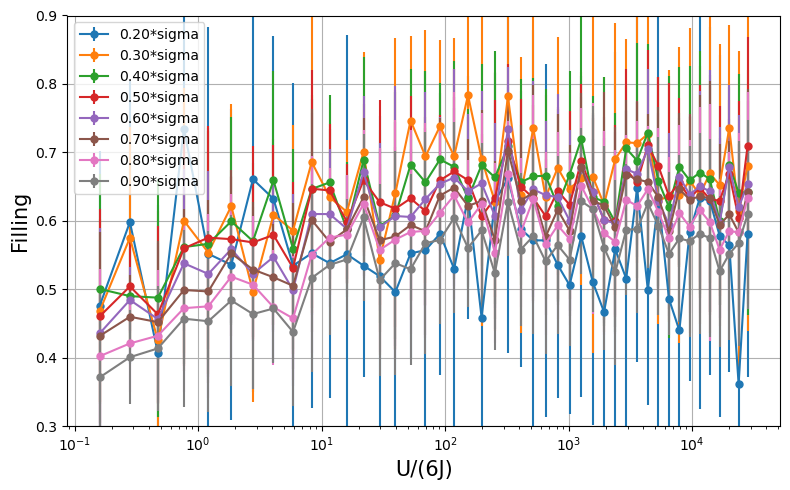

In [288]:
fig = plt.figure(figsize=[8,5], tight_layout = True)
ax1 = fig.add_subplot(1,1,1)
for i in range(len(width_list)):
    name_temp = "filling within {:.02f} sigma".format(width_list[i])
    name_2_temp = "filling err within {:.02f} sigma".format(width_list[i])
    ax1.errorbar(10**p(sorted_data["Unique param"]), sorted_data[name_temp], sorted_data[name_2_temp],fmt='-o',markersize=5,label="{:.2f}*sigma".format(width_list[i]))
ax1.set_xscale("log")
ax1.set_ylabel("Filling", fontsize = 15)
ax1.set_xlabel(r"U/(6J)", fontsize = 15)
ax1.set_ylim(0.3,0.9)
ax1.grid()
ax1.legend()

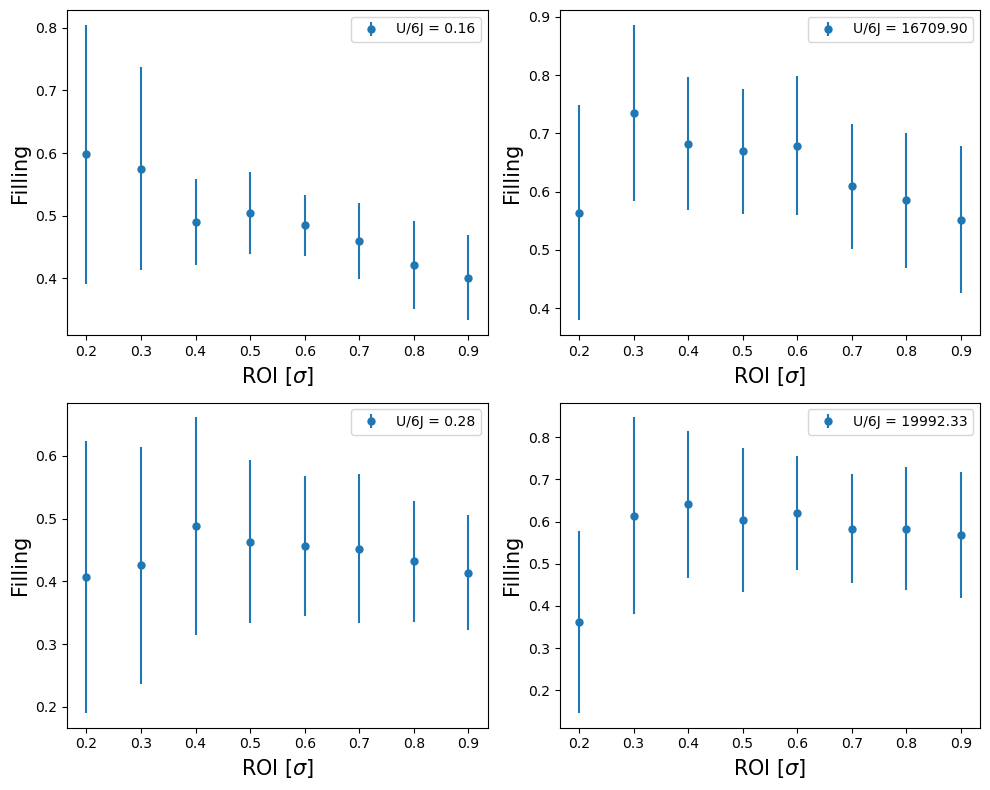

In [289]:
fig = plt.figure(figsize=[10,8], tight_layout = True)
# ax1 = fig.add_subplot(3,1,1)
# for i in range(len(width_list)):
#     name_temp = "filling within {:.02f} sigma ".format(width_list[i])
#     name_2_temp = "filling err within {:.02f} sigma ".format(width_list[i])
#     ax1.errorbar(10**p(sorted_data["Unique param"]), sorted_data[name_temp], sorted_data[name_2_temp],fmt='o',markersize=5,label="{:.2f}*sigma".format(width_list[i]))
# ax1.set_xscale("log")
# ax1.set_ylabel("Filling", fontsize = 15)
# ax1.set_xlabel(r"U/(6J)", fontsize = 15)
# ax1.set_ylim(0.3,0.9)
# ax1.grid()
# ax1.legend()

u_j_list = [1,len(unique_param)-3, 2,len(unique_param)-2]
# for i in range(7):
#     if i < 3:
#         continue
#     else:
#         ax = fig.add_subplot(3,2,i)
#         y_data = np.ravel(sorted_data[u_j_list[i-3]:u_j_list[i-3]+1])[1:len(width_list)+1]
#         y_err_data = np.ravel(sorted_data[u_j_list[i-3]:u_j_list[i-3]+1])[len(width_list)+1:2*len(width_list)+2]
#         ax.errorbar(width_list,y_data,y_err_data,fmt='o',markersize=5,label="U/6J = {:.2f}".format(10**p(unique_param[u_j_list[i-3]])))
#         ax.legend()
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    y_data = np.ravel(sorted_data[u_j_list[i]:u_j_list[i]+1])[1:len(width_list)+1]
    y_err_data = np.ravel(sorted_data[u_j_list[i]:u_j_list[i]+1])[len(width_list)+1:2*len(width_list)+2]
    ax.errorbar(width_list,y_data,y_err_data,fmt='o',markersize=5,label="U/6J = {:.2f}".format(10**p(unique_param[u_j_list[i]])))
    ax.set_xlabel(r"ROI $[\sigma]$", fontsize=15)
    ax.set_ylabel("Filling",fontsize=15)
    ax.legend()

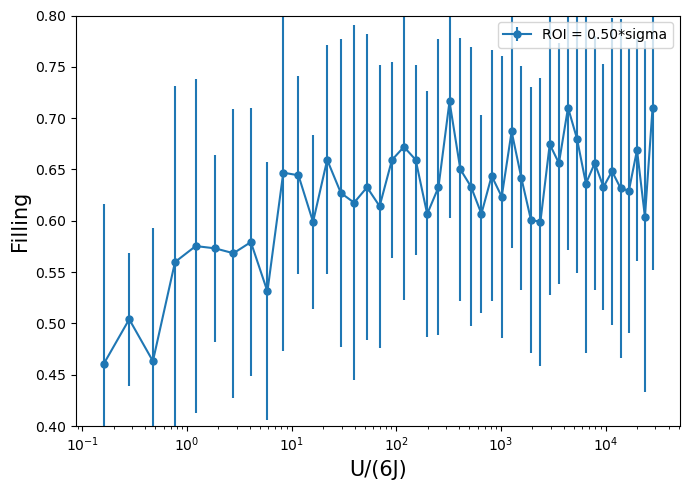

In [307]:
fig = plt.figure(figsize=[7,5], tight_layout = True)
ax1 = fig.add_subplot(1,1,1)
ax1.errorbar(10**p(sorted_data['Unique param']),sorted_data["filling within 0.50 sigma"],sorted_data["filling err within 0.50 sigma"],fmt='-o',markersize=5,label="ROI = 0.50*sigma")
ax1.set_xscale("log")
ax1.set_ylabel("Filling", fontsize = 15)
ax1.set_xlabel(r"U/(6J)", fontsize = 15)
ax1.set_ylim(0.4,0.8)
# ax1.grid(which="major",color='gray')
# ax1.grid(which="minor")
ax1.legend()

In [248]:
sorted_data.to_csv("SF_MI_filling_data.csv")